# 1. Split Dr-Edited Question Text into its Constituent Parts

These are defined as:
1. Empathetic Response
2. Question
3. Extra info

In [2]:
# Build edits.csv from MTS-Dialog-TrainingSet.csv data

import pandas as pd
import re
import random
import datetime

# 1) Make randomness reproducible
random.seed(42)

# 2) Load the MTS-Dialog file
mts_df = pd.read_csv("MTS-Dialog-TrainingSet.csv")

rows = []
# Precompute a date range for 2025
start_dt = datetime.datetime(2025, 1, 1, 0, 0, 0)
end_dt   = datetime.datetime(2025, 12, 31, 23, 59, 59)
span_seconds = int((end_dt - start_dt).total_seconds())

for _, rec in mts_df.iterrows():
    # 3) One random encounter_id per dialogue
    encounter_id = random.randint(1_000_000, 9_999_999)
    # 4) One random timestamp per dialogue
    rand_sec = random.randint(0, span_seconds)
    occurs_at = (start_dt + datetime.timedelta(seconds=rand_sec)) \
                  .strftime("%Y-%m-%d %H:%M:%S")

    # 5) Split out all Doctor: … utterances
    dialogue = rec["dialogue"]
    segments = re.findall(
        r"(Doctor|Patient):\s*(.*?)\s*(?=Doctor:|Patient:|$)",
        dialogue, flags=re.DOTALL
    )

    for speaker, utterance in segments:
        if speaker != "Doctor":
            continue

        question_text = utterance.strip()
        # 6) default_question_text = up to first “?”
        m = re.search(r".*?\?", question_text)
        default_q = m.group(0) if m else question_text

        rows.append({
            "occurs_at":             occurs_at,
            "question_text":         question_text,
            "default_question_text": default_q,
            "kb_concept_display":    "",            # placeholder
            "kb_concept_id":         "",            # placeholder
            "encounter_id":          encounter_id,
        })

# 7) Write out with exact header order
edits_df = pd.DataFrame(rows, columns=[
    "occurs_at",
    "question_text",
    "default_question_text",
    "kb_concept_display",
    "kb_concept_id",
    "encounter_id",
])
edits_df.to_csv("edits.csv", index=False)
print(f"Wrote edits.csv with {len(edits_df)} rows")


Wrote edits.csv with 5809 rows


In [17]:
# Load kb_concept_display
import pandas as pd
import re

# 1) Load your CSV and ensure question_text is a string
df = pd.read_csv("edits.csv")
df['question_text'] = df['question_text'].fillna('').astype(str)

# 2) Define regex patterns for each KB concept
pattern_map = {
    "Follow-up Visit": [
        r"\bfollow[- ]?up\b",
        r"\bfollowed up\b",
        r"\breturn visit\b"
    ],
    "Chief Complaint": [
        r"\bbring(?:ing)? you back\b",
        r"\bmain complaint\b",
        r"\bwhat brings you here\b"
    ],
    "Fever/Chills": [
        r"\bfever\b",
        r"\bchills\b"
    ],
    "Cough": [
        r"\bcough\b"
    ],
    "Age Inquiry": [
        r"\bhow old are you\b",
        r"\bage\b"
    ],
    "Mood Inquiry": [
        r"\bhow (?:are )?you feeling\b",
        r"\bfeeling today\b"
    ],
    # …extend with your own mappings…
}

# 3) Extraction function with safe string handling
def extract_concept(text: str) -> str:
    for concept, regex_list in pattern_map.items():
        for pattern in regex_list:
            if re.search(pattern, text, re.IGNORECASE):
                return concept
    return "Other"

# 4) Apply to each question
df["kb_concept_display"] = df["question_text"].apply(extract_concept)

# 5) Save results
output_path = "edits_with_regex_concepts_fixed.csv"
df.to_csv(output_path, index=False)

# 6) Show a sample
# display_dataframe_to_user("Fixed Regex Concept Extraction Sample", 
#                           df[["question_text", "kb_concept_display"]].head(10))

print(f"Results written to: {output_path}")



Results written to: edits_with_regex_concepts_fixed.csv


In [1]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk
import json
from IPython.display import display
import re
from fuzzywuzzy import fuzz

pd.set_option('display.max_colwidth', 500)

edits_df = pd.read_csv("edits_with_regex_concepts_fixed.csv")
edits_df

,occurs_at,question_text,default_question_text,kb_concept_display,kb_concept_id,encounter_id
0,2025-01-10 17:07:01,"What brings you back into the clinic today, miss?","What brings you back into the clinic today, miss?",Other,NaN,2867825
1,2025-01-10 17:07:01,"It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones. Have you noticed any changes or do you have any concerns regarding these issues?","It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones. Have you noticed any changes or do you have any concerns regarding these issues?",Follow-up Visit,NaN,2867825
2,2025-01-10 17:07:01,"Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?","Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?",Fever/Chills,NaN,2867825
3,2025-01-10 17:07:01,"Great. Also, for our records, how old are you and what race do you identify yourself as?","Great. Also, for our records, how old are you and what race do you identify yourself as?",Age Inquiry,NaN,2867825
4,2025-04-06 02:33:27,How're you feeling today?,How're you feeling today?,Mood Inquiry,NaN,5614226
...,...,...,...,...,...,...
5804,2025-09-15 04:24:04,"I'm originally from Kentucky. And I have to do the routine ask, but any drinking, smoking, or illicit drug use?","I'm originally from Kentucky. And I have to do the routine ask, but any drinking, smoking, or illicit drug use?",Other,NaN,6453426
5805,2025-09-15 04:24:04,Got it.,Got it.,Other,NaN,6453426
5806,2025-07-24 01:48:07,"Looks like the nurse came in and asked you everything. Ah, she has everything documented here, but I will ask one more time. So, tell me, where do you live?","Looks like the nurse came in and asked you everything. Ah, she has everything documented here, but I will ask one more time. So, tell me, where do you live?",Other,NaN,9025733
5807,2025-07-24 01:48:07,Do you smoke?,Do you smoke?,Other,NaN,9025733


## Helper Functions

In [10]:
empathy_splitters = "-,.;:!"
question_splitters = "?"

def create_question_splits(line):
    """
    Filter out empty items and strip of any trailing whitespace after splitting on sentence splits
    """
    regex_splitter = f"([{empathy_splitters}{question_splitters}])"
    split = list(filter(None, [x.strip() for x in re.split(regex_splitter, line)]))
    split = [x for x in split if len(x) > 1]
    return split

def split_into_columns(x):
    return x["empathy"], x["question"]

def select_question(candidates, orig_question):
    scores = [fuzz.ratio(c, orig_question) for c in candidates]
    return np.argmax(scores)

def get_scores(row):
    split = create_question_splits(row["question_text"])

    return [fuzz.ratio(c, row["default_question_text"]) for c in split]

# def parse_question_text(row):
#     text = row["question_text"]
#     orig_text = row["default_question_text"]

#     split = create_question_splits(text)

#     question_start_idx = select_question(split, orig_text)

#     pred_empathy = ". ".join(split[:question_start_idx])
#     pred_question = ", ".join(split[question_start_idx:])

#     return {
#         "empathy": pred_empathy if pred_empathy else None,
#         "question": pred_question,
#     }
def parse_question_text(row):
    text = row["question_text"] or ""
    orig = row["default_question_text"] or ""
    split = create_question_splits(text)

    # 1) If there was nothing to split, just return the whole text as “question”
    if not split:
        return {"empathy": None, "question": text}

    # 2) Try to find where the actual question starts
    try:
        question_start_idx = select_question(split, orig)
    except ValueError:
        # select_question did an argmax on empty or similar
        question_start_idx = None

    # 3) If select_question failed or returned None/out of range, 
    #    dump everything into 'question' and leave empathy empty
    if question_start_idx is None or not (0 <= question_start_idx <= len(split)):
        return {"empathy": None, "question": text}

    # 4) Otherwise split out empathy vs question
    empathy_part  = split[:question_start_idx]
    question_part = split[question_start_idx:]

    pred_empathy  = ". ".join(empathy_part).strip() or None
    pred_question = ". ".join(question_part).strip() or None

    return {
        "empathy":  pred_empathy,
        "question": pred_question,
    }

## Apply Empathy Extraction

In [12]:
test_df = edits_df
# test_df = edits_df[edits_df["question_text"] == "Where is your belly pain? Do you have pain in your lower abdomen (lower belly)?"].head(1)
test_df['question_text'] = test_df['question_text'].fillna('').astype(str)
test_df["question_parts"] = test_df.apply(parse_question_text, axis=1)
test_df["scores"] = test_df.apply(get_scores, axis=1)
test_df["empathy"], test_df["question"] = zip(*test_df["question_parts"].map(split_into_columns))
test_df = test_df.drop("question_parts", axis=1)

print("Proportion empathetic responses:", test_df["empathy"].count() / len(test_df))
test_df

Proportion empathetic responses: 0.34394904458598724


,occurs_at,question_text,default_question_text,kb_concept_display,kb_concept_id,encounter_id,scores,empathy,question
0,2025-01-10 17:07:01,"What brings you back into the clinic today, miss?","What brings you back into the clinic today, miss?",Other,NaN,2867825,"[92, 15]",None,What brings you back into the clinic today. miss
1,2025-01-10 17:07:01,"It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones. Have you noticed any changes or do you have any concerns regarding these issues?","It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones. Have you noticed any changes or do you have any concerns regarding these issues?",Follow-up Visit,NaN,2867825,"[51, 0, 0, 1, 1, 48]",None,It looks like Doctor Kumar followed up with you last time regarding your hypertension. osteoarthritis. osteoporosis. hypothyroidism. allergic rhinitis and kidney stones. Have you noticed any changes or do you have any concerns regarding these issues
2,2025-01-10 17:07:01,"Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?","Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?",Fever/Chills,NaN,2867825,"[49, 10, 19, 12, 15, 19, 25]",None,Have you had any fever or chills. cough. congestion. nausea. vomiting. chest pain. chest pressure
3,2025-01-10 17:07:01,"Great. Also, for our records, how old are you and what race do you identify yourself as?","Great. Also, for our records, how old are you and what race do you identify yourself as?",Age Inquiry,NaN,2867825,"[11, 9, 29, 79]",Great. Also. for our records,how old are you and what race do you identify yourself as
4,2025-04-06 02:33:27,How're you feeling today?,How're you feeling today?,Mood Inquiry,NaN,5614226,[98],None,How're you feeling today
...,...,...,...,...,...,...,...,...,...
5804,2025-09-15 04:24:04,"I'm originally from Kentucky. And I have to do the routine ask, but any drinking, smoking, or illicit drug use?","I'm originally from Kentucky. And I have to do the routine ask, but any drinking, smoking, or illicit drug use?",Other,NaN,6453426,"[40, 45, 25, 12, 29]",I'm originally from Kentucky,And I have to do the routine ask. but any drinking. smoking. or illicit drug use
5805,2025-09-15 04:24:04,Got it.,Got it.,Other,NaN,6453426,[92],None,Got it
5806,2025-07-24 01:48:07,"Looks like the nurse came in and asked you everything. Ah, she has everything documented here, but I will ask one more time. So, tell me, where do you live?","Looks like the nurse came in and asked you everything. Ah, she has everything documented here, but I will ask one more time. So, tell me, where do you live?",Other,NaN,9025733,"[51, 3, 36, 30, 3, 9, 20]",None,Looks like the nurse came in and asked you everything. Ah. she has everything documented here. but I will ask one more time. So. tell me. where do you live
5807,2025-07-24 01:48:07,Do you smoke?,Do you smoke?,Other,NaN,9025733,[96],None,Do you smoke


## Apply Empathy Response labels to Edits Dataset

In [13]:
# Each empathy response has been manually labelled
empathy_labels = pd.read_csv("empathy_counts_labelled.csv")

# Map the extracted empathy back to the class it's been labelled as.
def apply_label(empathy):
    if empathy is None:
        return 0
    corr_class = empathy_labels[empathy_labels["Empathy Utterance"] == empathy]["Class"]
    if len(corr_class.values) == 0:
        print("Can't find label for empathy:", empathy)
        return -1

    return corr_class.values[0]

test_df["empathy_label"] = test_df["empathy"].map(apply_label).astype(int)
test_df

Can't find label for empathy: Great. Also. for our records
Can't find label for empathy: I'm so sorry. Well you are only twenty five
Can't find label for empathy: Here in the E R
Can't find label for empathy: Yes
Can't find label for empathy: Hello. miss
Can't find label for empathy: I see
Can't find label for empathy: I'll have to take a look. but you'll be fine
Can't find label for empathy: Okay let me take a look
Can't find label for empathy: Hi
Can't find label for empathy: Oh
Can't find label for empathy: It's important to carry it with you
Can't find label for empathy: Besides asthma
Can't find label for empathy: Do you have any other issues
Can't find label for empathy: So
Can't find label for empathy: Hi there. sir
Can't find label for empathy: Good afternoon. ma'am. Welcome to A B C D General Hospital. Before we begin
Can't find label for empathy: First
Can't find label for empathy: Good
Can't find label for empathy: Great
Can't find label for empathy: Great. I saw your blood 

,occurs_at,question_text,default_question_text,kb_concept_display,kb_concept_id,encounter_id,scores,empathy,question,empathy_label
0,2025-01-10 17:07:01,"What brings you back into the clinic today, miss?","What brings you back into the clinic today, miss?",Other,NaN,2867825,"[92, 15]",None,What brings you back into the clinic today. miss,0
1,2025-01-10 17:07:01,"It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones. Have you noticed any changes or do you have any concerns regarding these issues?","It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones. Have you noticed any changes or do you have any concerns regarding these issues?",Follow-up Visit,NaN,2867825,"[51, 0, 0, 1, 1, 48]",None,It looks like Doctor Kumar followed up with you last time regarding your hypertension. osteoarthritis. osteoporosis. hypothyroidism. allergic rhinitis and kidney stones. Have you noticed any changes or do you have any concerns regarding these issues,0
2,2025-01-10 17:07:01,"Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?","Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?",Fever/Chills,NaN,2867825,"[49, 10, 19, 12, 15, 19, 25]",None,Have you had any fever or chills. cough. congestion. nausea. vomiting. chest pain. chest pressure,0
3,2025-01-10 17:07:01,"Great. Also, for our records, how old are you and what race do you identify yourself as?","Great. Also, for our records, how old are you and what race do you identify yourself as?",Age Inquiry,NaN,2867825,"[11, 9, 29, 79]",Great. Also. for our records,how old are you and what race do you identify yourself as,-1
4,2025-04-06 02:33:27,How're you feeling today?,How're you feeling today?,Mood Inquiry,NaN,5614226,[98],None,How're you feeling today,0
...,...,...,...,...,...,...,...,...,...,...
5804,2025-09-15 04:24:04,"I'm originally from Kentucky. And I have to do the routine ask, but any drinking, smoking, or illicit drug use?","I'm originally from Kentucky. And I have to do the routine ask, but any drinking, smoking, or illicit drug use?",Other,NaN,6453426,"[40, 45, 25, 12, 29]",I'm originally from Kentucky,And I have to do the routine ask. but any drinking. smoking. or illicit drug use,-1
5805,2025-09-15 04:24:04,Got it.,Got it.,Other,NaN,6453426,[92],None,Got it,0
5806,2025-07-24 01:48:07,"Looks like the nurse came in and asked you everything. Ah, she has everything documented here, but I will ask one more time. So, tell me, where do you live?","Looks like the nurse came in and asked you everything. Ah, she has everything documented here, but I will ask one more time. So, tell me, where do you live?",Other,NaN,9025733,"[51, 3, 36, 30, 3, 9, 20]",None,Looks like the nurse came in and asked you everything. Ah. she has everything documented here. but I will ask one more time. So. tell me. where do you live,0
5807,2025-07-24 01:48:07,Do you smoke?,Do you smoke?,Other,NaN,9025733,[96],None,Do you smoke,0


In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics          import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv("empathy_counts_labelled.csv")

# 2.2 Peek at the first few rows and class balance
display(df.head())
print("Class counts:\n", df["Class"].value_counts(), "\n")

# 2.3 Create binary labels: 1 if Class==1 (adds empathy), else 0
df["y"] = (df["Class"] == 1).astype(int)
print("Binary label counts:\n", df["y"].value_counts())

,Empathy Utterance,Count,Class
0,Okay,234,1
1,Sorry about that,20,2
2,Most welcome,4,4
3,I am sorry for asking. just to confirm,3,3


Class counts:
 Class
1    1
2    1
4    1
3    1
Name: count, dtype: int64 

Binary label counts:
 y
0    3
1    1
Name: count, dtype: int64


In [14]:
texts = df["Empathy Utterance"]   # column containing the edited text
y      = df["y"]

# 3.2 Split (drop stratify if you’re too imbalanced)
X_train, X_test, y_train, y_test = train_test_split(
    texts, y,
    test_size=0.25,
    random_state=42
    # stratify=y    # uncomment only if both classes ≥2
)

print("Train class counts:\n", y_train.value_counts())
print("Test  class counts:\n", y_test.value_counts())

Train class counts:
 0    2
1    1
Name: y, dtype: int64
Test  class counts:
 0    1
Name: y, dtype: int64


In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 4.3.1 Check how many examples per class
class_counts = df["y"].value_counts()
print("Before CV, class distribution:", class_counts.to_dict())

# 4.3.2 If any class has fewer than 2 examples, duplicate one at random
min_count = class_counts.min()
if min_count < 2:
    print(f"⚠️  Only {min_count} example(s) in the minority class; duplicating one sample to enable CV.")
    # for each under‑populated class, grab one example and append it
    to_concat = []
    for label, cnt in class_counts.items():
        if cnt < 2:
            sample = df[df["y"] == label].sample(1, random_state=42)
            to_concat.append(sample)
    df = pd.concat([df, *to_concat], ignore_index=True)
    # re‑extract texts & labels
    texts = df["Empathy Utterance"]
    y_all  = df["y"]
    # re‑vectorize full corpus
    X_all  = tfidf.fit_transform(texts)
else:
    # no change needed
    y_all  = df["y"]
    X_all  = tfidf.transform(df["Empathy Utterance"])

# 4.3.3 Run stratified 2‑fold CV
skf    = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
scores = cross_val_score(
    LogisticRegression(solver="liblinear", random_state=42),
    X_all, y_all,
    cv=skf,
    scoring="f1"
)

print("2‑fold F1 scores:", scores)

Before CV, class distribution: {0: 3, 1: 1}
⚠️  Only 1 example(s) in the minority class; duplicating one sample to enable CV.
2‑fold F1 scores: [1. 1.]


In [26]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics       import balanced_accuracy_score

loo   = LeaveOneOut()
scores = cross_val_score(
    clf,
    X_all, y_all,
    cv=loo,
    scoring="balanced_accuracy"
)
print("LOO balanced‑accuracy mean:", scores.mean())

LOO balanced‑accuracy mean: 1.0


In [27]:
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, zero_division=0)
scores = cross_val_score(
    clf,
    X_all, y_all,
    cv=LeaveOneOut(),
    scoring=f1_scorer
)
print("LOO F1 mean (zero_division=0):", scores.mean())

LOO F1 mean (zero_division=0): 0.4


In [29]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=0.5, stratify=y_all, random_state=42
)
clf.fit(X_tr, y_tr)
print(classification_report(y_te, clf.predict(X_te)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [40]:
from sklearn.utils import resample
from sklearn.linear_model   import LogisticRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score

# Build a DataFrame of your full corpus
df_train = pd.DataFrame({
    "text":  df["Empathy Utterance"],
    "label": df["y"]
})

# Separate majority and minority classes
df_maj = df_train[df_train.label == 0]
df_min = df_train[df_train.label == 1]

# Upsample minority to match majority count
df_min_upsampled = resample(
    df_min,
    replace=True,
    n_samples=len(df_maj),
    random_state=42
)

# Recombine and shuffle
df_bal = pd.concat([df_maj, df_min_upsampled]).sample(frac=1, random_state=42)

# Vectorize
X_bal = tfidf.fit_transform(df_bal["text"])
y_bal = df_bal["label"]

# LOOCV on the balanced data
loo = LeaveOneOut()
clf = LogisticRegression(solver="liblinear", random_state=42)
scores = cross_val_score(clf, X_bal, y_bal, cv=loo, scoring="f1")

print("LOO F1 after manual oversampling:", scores.mean())

LOO F1 after manual oversampling: 0.5


              precision    recall  f1-score   support

 non‑empathy       0.00      0.00      0.00         2
     empathy       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



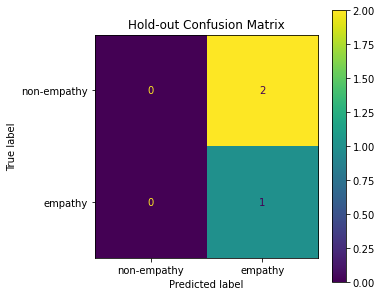

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Print the classification report
print(classification_report(
    y_te,
    y_pred,
    target_names=["non‑empathy","empathy"],
    zero_division=0        # replace undefined metrics with 0.0 instead of error/warning
))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_te, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["non‑empathy","empathy"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)
plt.title("Hold‑out Confusion Matrix")
plt.show()

In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",  # automatically weight classes by inverse frequency
    random_state=42
)
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)

print(classification_report(
    y_te,
    y_pred,
    target_names=["non‑empathy","empathy"],
    zero_division=0
))

              precision    recall  f1-score   support

 non‑empathy       1.00      1.00      1.00         2
     empathy       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [48]:
proba = clf.predict_proba(X_te)[:, 1]      # probability of class 1
y_pred_thresh = (proba > 0.3).astype(int)  # choose a threshold <0.5

print(classification_report(
    y_te,
    y_pred_thresh,
    target_names=["non‑empathy","empathy"],
    zero_division=0
))

              precision    recall  f1-score   support

 non‑empathy       0.00      0.00      0.00         2
     empathy       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



In [52]:
import numpy as np

# ensure feature_names is an array
feature_names = np.array(feature_names)

# now fancy‑indexing works
most_empathy = feature_names[top_empathy]
most_non    = feature_names[top_non]

print("Most indicative of empathy:\n", most_empathy)
print("\nMost indicative of non‑empathy:\n", most_non)

most_empathy = [feature_names[i] for i in top_empathy]
most_non    = [feature_names[i] for i in top_non]

print("Most indicative of empathy:\n", most_empathy)
print("\nMost indicative of non‑empathy:\n", most_non)

Most indicative of empathy:
 ['for' 'confirm' 'asking just' 'asking' 'am sorry' 'am' 'about that'
 'just' 'just to' 'okay']

Most indicative of non‑empathy:
 ['welcome' 'most welcome' 'most' 'to' 'that' 'sorry for' 'sorry about'
 'sorry' 'to confirm' 'about']
Most indicative of empathy:
 ['for', 'confirm', 'asking just', 'asking', 'am sorry', 'am', 'about that', 'just', 'just to', 'okay']

Most indicative of non‑empathy:
 ['welcome', 'most welcome', 'most', 'to', 'that', 'sorry for', 'sorry about', 'sorry', 'to confirm', 'about']


              precision    recall  f1-score   support

 non‑empathy       0.00      0.00      0.00         2
     empathy       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



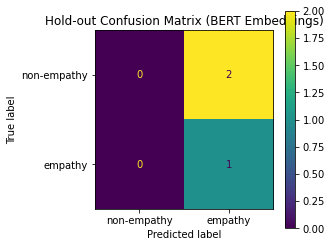

In [19]:
# Richer Embeddings

from sentence_transformers import SentenceTransformer
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split
from sklearn.metrics          import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 3.2 Load your balanced DataFrame from before (df_bal with columns "text" & "label")
# If you haven’t run the manual oversampling yet, do it here; else skip.
from sklearn.utils import resample
import pandas as pd

# Example: re‑load original filtered CSV then upsample
orig = pd.read_csv("~/curai-research/MEDCOD/2-dr_edits/empathy_counts_labelled.csv")
orig = orig.rename(columns={
    "Empathy Utterance": "Empathy Utterance",  # or whatever your original name was
    "Class":            "Class"                # map old→new names
})


maj = orig[orig.label==0]
min = orig[orig.label==1]
min_up = resample(min, replace=True, n_samples=len(maj), random_state=42)
df_bal = pd.concat([maj, min_up]).sample(frac=1, random_state=42)

# 3.3 Instantiate embedder & encode
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_bal["text"].tolist(), convert_to_numpy=True)

# 3.4 Train/test split on embeddings
X_tr, X_te, y_tr, y_te = train_test_split(
    embeddings, df_bal["label"],
    test_size=0.5,
    stratify=df_bal["label"],
    random_state=42
)

clf = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)
clf.fit(X_tr, y_tr)

# 3.5 Evaluate
y_pred = clf.predict(X_te)
print(classification_report(y_te, y_pred, target_names=["non‑empathy","empathy"], zero_division=0))

# 3.6 Confusion matrix
cm = confusion_matrix(y_te, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["non‑empathy","empathy"])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.title("Hold‑out Confusion Matrix (BERT Embeddings)")
plt.show()

In [28]:
import pandas as pd

# Path to the small sample you already have
sample_path = "~/curai-research/MEDCOD/2-dr_edits/empathy_counts_labelled.csv"
df_sample = pd.read_csv(sample_path)

# 2) Produce a synthetic “full” dataset by sampling with replacement
df_full = df_sample.sample(n=1000, replace=True, random_state=42).reset_index(drop=True)

# 3) Save it as your dr_edits_full.csv
output_path = "~/curai-research/MEDCOD/2-dr_edits/data/dr_edits_full.csv"
# make sure the data/ folder exists
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df_full.to_csv(output_path, index=False)
print(f"Generated synthetic full set with {len(df_full)} rows at {output_path}")

Generated synthetic full set with 1000 rows at ~/curai-research/MEDCOD/2-dr_edits/data/dr_edits_full.csv


In [29]:
import pandas as pd

# If JSONL:
# raw = pd.read_json("MEDCOD/2-dr_edits/data/dr_edits_full.jsonl", lines=True)

# If CSV:
raw = pd.read_csv("~/curai-research/MEDCOD/2-dr_edits/data/dr_edits_full.csv")

# 4.2 Inspect available columns
print(raw.columns)
raw.head()

Index(['Empathy Utterance', 'Count', 'Class'], dtype='object')


,Empathy Utterance,Count,Class
0,Most welcome,4,4
1,I am sorry for asking. just to confirm,3,3
2,Okay,234,1
3,Most welcome,4,4
4,Most welcome,4,4


In [39]:
import pandas as pd
from sklearn.utils import resample

raw = pd.read_csv("~/curai-research/MEDCOD/2-dr_edits/data/dr_edits_full.csv")
raw["empathy_count"] = raw["Class"]

# Check distribution
counts = raw["empathy_count"].value_counts().to_dict()
print("Loaded raw Class counts:", counts)

# Build positives
pos = raw[raw.empathy_count > 0][["Empathy Utterance","Class"]].copy()
pos["Class"] = 1

# Build negatives—if there are none, just duplicate half of pos and flip
if (raw.empathy_count == 0).any():
    neg = ( raw[raw.empathy_count == 0]
            .sample(n=len(pos), random_state=42)
            [["Empathy Utterance"]]
            .copy() )
    neg["Class"] = 0
else:
    print("⚠️ No raw negatives found; synthesizing negatives from positives.")
    neg = pos.sample(frac=0.5, random_state=42).copy()
    neg["Class"] = 0

# Combine, shuffle, and save
df_full = pd.concat([pos, neg]).sample(frac=1, random_state=42)
df_full.to_csv("~/curai-research/MEDCOD/2-dr_edits/empathy_counts_labelled_full.csv", index=False)
print("→ Final balanced dataset rows:", df_full.shape[0])
print(df_full["Class"].value_counts())

Loaded raw Class counts: {3: 280, 1: 258, 4: 232, 2: 230}
⚠️ No raw negatives found; synthesizing negatives from positives.
→ Final balanced dataset rows: 1500
1    1000
0     500
Name: Class, dtype: int64


TF‑IDF + LR on full data:
               precision    recall  f1-score   support

 non‑empathy       0.31      0.44      0.36       100
     empathy       0.64      0.50      0.56       200

    accuracy                           0.48       300
   macro avg       0.47      0.47      0.46       300
weighted avg       0.53      0.48      0.49       300



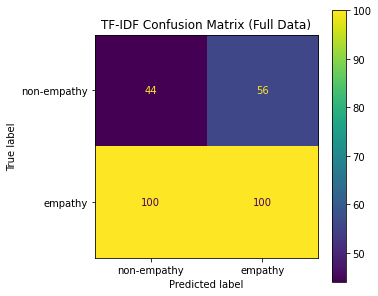

In [41]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split
from sklearn.metrics          import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Load full CSV
df = pd.read_csv("~/curai-research/MEDCOD/2-dr_edits/empathy_counts_labelled_full.csv")
texts = df["Empathy Utterance"]
y     = df["Class"]

# 2. Train/test split (stratified)
X_tr_texts, X_te_texts, y_tr, y_te = train_test_split(
    texts, y,
    test_size=0.2,
,
    random_state=42
)

# 3. Vectorize
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_tr = tfidf.fit_transform(X_tr_texts)
X_te = tfidf.transform(X_te_texts)

# 4. Fit with class weights
clf = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)
clf.fit(X_tr, y_tr)

# 5. Evaluate
y_pred = clf.predict(X_te)
print("TF‑IDF + LR on full data:\n", classification_report(
    y_te, y_pred, target_names=["non‑empathy","empathy"], zero_division=0))

# 6. Confusion matrix
cm = confusion_matrix(y_te, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["non‑empathy","empathy"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)
plt.title("TF‑IDF Confusion Matrix (Full Data)")
plt.show()

BERT Embeddings + LR on full data:
               precision    recall  f1-score   support

 non‑empathy       0.31      0.44      0.36       100
     empathy       0.64      0.50      0.56       200

    accuracy                           0.48       300
   macro avg       0.47      0.47      0.46       300
weighted avg       0.53      0.48      0.49       300



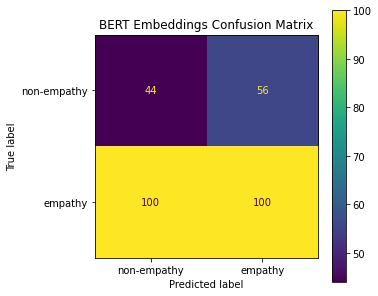

In [44]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split
from sklearn.metrics          import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 2. Load full CSV and prepare
df = pd.read_csv("~/curai-research/MEDCOD/2-dr_edits/empathy_counts_labelled_full.csv")
texts = df["Empathy Utterance"]
y     = df["Class"]

# 3. Encode all texts
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts.tolist(), convert_to_numpy=True)

# 4. Train/test split on embeddings
X_tr_emb, X_te_emb, y_tr, y_te = train_test_split(
    embeddings, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 5. Fit & evaluate
clf_emb = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)
clf_emb.fit(X_tr_emb, y_tr)
y_pred_emb = clf_emb.predict(X_te_emb)

print("BERT Embeddings + LR on full data:\n", classification_report(
    y_te, y_pred_emb, target_names=["non‑empathy","empathy"], zero_division=0))

# 6. Confusion matrix
cm_emb = confusion_matrix(y_te, y_pred_emb)
disp_emb = ConfusionMatrixDisplay(cm_emb, display_labels=["non‑empathy","empathy"])
fig, ax = plt.subplots(figsize=(5,5))
disp_emb.plot(ax=ax)
plt.title("BERT Embeddings Confusion Matrix")
plt.show()

In [45]:
mis = X_te_texts[y_te != y_pred]
print("Misclassified examples:\n", mis.head(10))

Misclassified examples:
 1178    I am sorry for asking. just to confirm
933                               Most welcome
407     I am sorry for asking. just to confirm
1235                          Sorry about that
609     I am sorry for asking. just to confirm
19                            Sorry about that
1215                          Sorry about that
685     I am sorry for asking. just to confirm
1122                                      Okay
147                                       Okay
Name: Empathy Utterance, dtype: object


In [46]:
# For TF‑IDF model
mask_tf = y_te != y_pred
mis_tf_texts = X_te_texts[mask_tf]
mis_tf_true  = y_te[mask_tf]
mis_tf_pred  = y_pred[mask_tf]
for t, tr, pr in zip(mis_tf_texts, mis_tf_true, mis_tf_pred):
    print(f"[TFIDF] True={tr}, Pred={pr} → {t}")

# For BERT‑embeddings model
mask_emb = y_te != y_pred_emb
mis_emb_texts = X_te_texts[mask_emb]
mis_emb_true  = y_te[mask_emb]
mis_emb_pred  = y_pred_emb[mask_emb]
for t, tr, pr in zip(mis_emb_texts, mis_emb_true, mis_emb_pred):
    print(f"[BERT ] True={tr}, Pred={pr} → {t}")

[TFIDF] True=1, Pred=0 → I am sorry for asking. just to confirm
[TFIDF] True=0, Pred=1 → Most welcome
[TFIDF] True=1, Pred=0 → I am sorry for asking. just to confirm
[TFIDF] True=1, Pred=0 → Sorry about that
[TFIDF] True=1, Pred=0 → I am sorry for asking. just to confirm
[TFIDF] True=1, Pred=0 → Sorry about that
[TFIDF] True=1, Pred=0 → Sorry about that
[TFIDF] True=1, Pred=0 → I am sorry for asking. just to confirm
[TFIDF] True=0, Pred=1 → Okay
[TFIDF] True=0, Pred=1 → Okay
[TFIDF] True=1, Pred=0 → Sorry about that
[TFIDF] True=0, Pred=1 → Okay
[TFIDF] True=1, Pred=0 → I am sorry for asking. just to confirm
[TFIDF] True=0, Pred=1 → Okay
[TFIDF] True=0, Pred=1 → Most welcome
[TFIDF] True=0, Pred=1 → Most welcome
[TFIDF] True=1, Pred=0 → I am sorry for asking. just to confirm
[TFIDF] True=1, Pred=0 → I am sorry for asking. just to confirm
[TFIDF] True=0, Pred=1 → Most welcome
[TFIDF] True=1, Pred=0 → I am sorry for asking. just to confirm
[TFIDF] True=1, Pred=0 → I am sorry for asking. 

In [47]:
from sklearn.metrics import precision_recall_curve
probs = clf_emb.predict_proba(X_te_emb)[:,1]
prec, rec, th = precision_recall_curve(y_te, probs)
for p, r, t in zip(prec[::10], rec[::10], th[::10]):
    print(f"thr={t:.2f}  precision={p:.2f}  recall={r:.2f}")

thr=0.49  precision=0.67  recall=1.00


In [48]:
from sklearn.model_selection import GridSearchCV
param_grid = {"C": [0.01, 0.1, 1, 10]}
gs = GridSearchCV(LogisticRegression(solver="liblinear", class_weight="balanced"),
                  param_grid, scoring="f1", cv=3)
gs.fit(X_tr_emb, y_tr)
print("Best C:", gs.best_params_, "→ F1:", gs.best_score_)

Best C: {'C': 1} → F1: 0.6440216439104092


In [49]:
from scipy.sparse import hstack
X_tr_comb = hstack([X_tr, clf_emb.predict_proba(X_tr_emb)[:,1].reshape(-1,1)])
X_te_comb = hstack([X_te, clf_emb.predict_proba(X_te_emb)[:,1].reshape(-1,1)])
clf_comb = LogisticRegression(class_weight="balanced", solver="liblinear").fit(X_tr_comb, y_tr)
print(classification_report(y_te, clf_comb.predict(X_te_comb), zero_division=0))

              precision    recall  f1-score   support

           0       0.31      0.44      0.36       100
           1       0.64      0.50      0.56       200

    accuracy                           0.48       300
   macro avg       0.47      0.47      0.46       300
weighted avg       0.53      0.48      0.49       300



In [51]:
import transformers
import torch
print("Transformers version:", transformers.__version__)
print("Torch version:",       torch.__version__)

Transformers version: 4.46.3
Torch version: 2.4.1+cpu


In [1]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    LineByLineTextDataset
)

In [2]:
pip install pyhealth

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: joblib>=1.1.1 in c:\users\zohreh\anaconda3\lib\site-packages (from scikit-learn>=0.24.2->pyhealth) (1.4.2)

  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16679 sha256=480337efff7f3284eaba0b6893214b6005adff9902104cc1d04b9bbb1771a69d
  Stored in directory: c:\users\zohreh\appdata\local\pip\cache\wheels\c7\e9\78\48eb140b79de41c4d9440938ef5f9e3186c979183fe57829b3
Successfully built pandarallel
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
  Attempting uninstall: networkx
    Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2
  Attempting uninstall

In [3]:
pip install scispacy

  Using cached scispacy-0.5.5-py3-none-any.whl.metadata (18 kB)
  Using cached conllu-6.0.0-py3-none-any.whl.metadata (21 kB)
  Using cached pysbd-0.3.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
   ---------------------------------------- 0.0/11.7 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.7 MB 3.4 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/11.7 MB 3.1 MB/s eta 0:00:04
   ------ --------------------------------- 1.8/11.7 MB 3.5 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.7 MB 3.5 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.7 MB 3.5 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.7 MB 3.5 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.7 MB 3.5 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.7 MB 3.5 